In [23]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import matplotlib.pyplot as plt

In [24]:
import torchvision.transforms as transforms
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transforms.Compose([transforms.Resize(224),
                                                                                                           transforms.RandomHorizontalFlip(),
                                                                                                           transforms.ToTensor()]))
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transforms.Compose([transforms.Resize(224),
                                                                                                           transforms.RandomHorizontalFlip(),
                                                                                                           transforms.ToTensor()]))
train_loader=torch.utils.data.DataLoader(trainset,batch_size=100,shuffle=True)
test_loader=torch.utils.data.DataLoader(testset,batch_size=100,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
image,label=trainset[0]

image.shape

torch.Size([3, 224, 224])

In [26]:
len(trainset),len(testset)

(50000, 10000)

In [27]:
class_names=trainset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

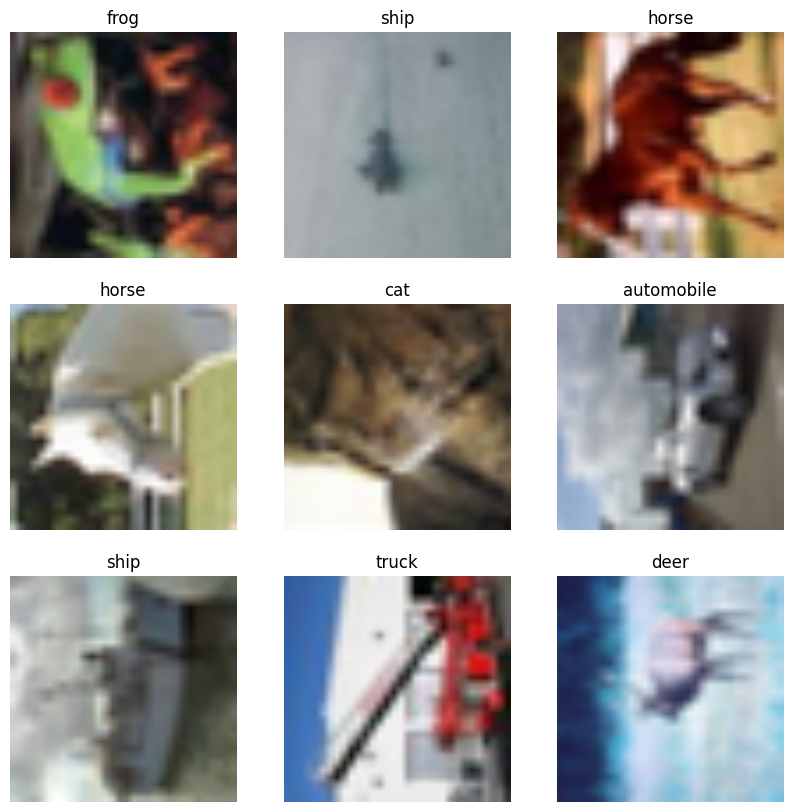

In [28]:
torch.manual_seed(42)

fig=plt.figure(figsize=(10,10))

for i in range(1,10):
  randindx=torch.randint(0,len(trainset),size=[1]).item()
  img,label=trainset[randindx]
  fig.add_subplot(3,3,i)
  plt.imshow(img.T,cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [29]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([100, 3, 224, 224]), torch.Size([100]))

In [30]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [31]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [32]:
class AlexNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.ConvBlock=nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2),
        nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,stride=1,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2),
        nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2)

    )

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=256,out_features=4096,),
        nn.Linear(in_features=4096,out_features=4096),
        nn.Linear(in_features=4096,out_features=10)
    )

  def forward(self,x:torch.tensor):
    x=self.ConvBlock(x)
    x=self.classifier(x)
    return x

In [33]:
torch.manual_seed(42)
from helper_functions import accuracy_fn


model=AlexNet().to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.1)
model

AlexNet(
  (ConvBlock): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=4096, bias=True)
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): Linear(in_features=4096, out_features=10, bias=True)
  )
)

In [34]:
def train_step(model:nn.Module,dataloader:torch.utils.data.DataLoader,loss_fn:nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  model.train()
  model.to(device)
  train_loss,train_acc=0,0

  for batch,(X,y) in enumerate(dataloader):
    X,y=X.to(device),y.to(device)
    y_pred=model(X)

    loss=loss_fn(y_pred,y)
    train_loss+=loss
    train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss/=len(dataloader)
  train_acc/=len(dataloader)
  print(f"Train loss: {train_loss} | Train accuracy: {train_acc}%")


def test_step(model:nn.Module,dataloader:torch.utils.data.DataLoader,loss_fn:nn.Module,accuracy_fn,device:torch.device=device):
  test_loss,test_acc=0,0
  model.eval()
  model.to(device)
  with torch.inference_mode():
    for X,y in dataloader:
      X,y=X.to(device),y.to(device)
      test_pred=model(X)
      test_loss+=loss_fn(test_pred,y)
      test_acc+= accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))

    test_loss/=len(dataloader)
    test_acc/=len(dataloader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [35]:
torch.manual_seed(42)

from tqdm.auto import tqdm
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs=20

for epoch in range(epochs):
  print(f"Epoch: {epoch}\n---------")
  train_step(dataloader=train_loader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

  test_step(dataloader=test_loader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )



Epoch: 0
---------
Train loss: 2.2990174293518066 | Train accuracy: 11.016%
Test loss: 2.29519 | Test accuracy: 10.43%

Epoch: 1
---------
Train loss: 2.2955901622772217 | Train accuracy: 11.626%
Test loss: 2.28592 | Test accuracy: 12.23%

Epoch: 2
---------
Train loss: 2.2904324531555176 | Train accuracy: 12.43%
Test loss: 2.24895 | Test accuracy: 15.55%

Epoch: 3
---------
Train loss: 2.180630683898926 | Train accuracy: 18.708%
Test loss: 2.19113 | Test accuracy: 15.26%

Epoch: 4
---------
Train loss: 2.0674679279327393 | Train accuracy: 22.922%
Test loss: 1.94071 | Test accuracy: 29.37%

Epoch: 5
---------
Train loss: 1.9107645750045776 | Train accuracy: 29.912%
Test loss: 1.91758 | Test accuracy: 33.47%

Epoch: 6
---------
Train loss: 1.6840977668762207 | Train accuracy: 39.004%
Test loss: 1.52777 | Test accuracy: 44.40%

Epoch: 7
---------
Train loss: 1.515343189239502 | Train accuracy: 45.448%
Test loss: 1.45786 | Test accuracy: 46.62%

Epoch: 8
---------
Train loss: 1.3702145814

In [40]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code
model_1_results = eval_model(model=model, data_loader=test_loader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
)
model_1_results

{'model_name': 'AlexNet', 'model_loss': 0.927104651927948, 'model_acc': 70.79}